# Building a classifier for detecting tuberculosis in chest X-rays
By Jonathan Feenstra (s1024219) and Justin Huberts (s1030368)

In this project we attempt to construct a binary Extreme Learning Machine (ELM) classifier to detect tuberculosis in lung X-rays. The U.S. National Library of Medicine has made two datasets of postero-anterior chest radiographs available which we will use to train and test our model: the Montgomery County Set and the Shenzen Set (Jaeger et al., 2014).

The datasets are available for download at [https://ceb.nlm.nih.gov/repositories/tuberculosis-chest-x-ray-image-data-sets/](https://ceb.nlm.nih.gov/repositories/tuberculosis-chest-x-ray-image-data-sets/)

## Sources
- Jaeger, S., Candemir, S., Antani, S., Wáng, Y., Lu, P., & Thoma, G. (2014). Two public chest X-ray datasets for computer-aided screening of pulmonary diseases. _Quantitative Imaging In Medicine And Surgery, 4_(6), 475-477.

## Some example images:

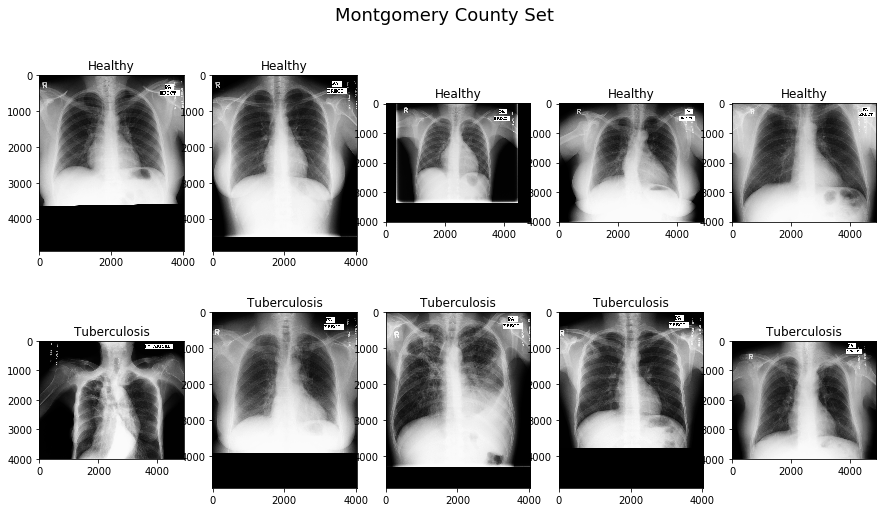

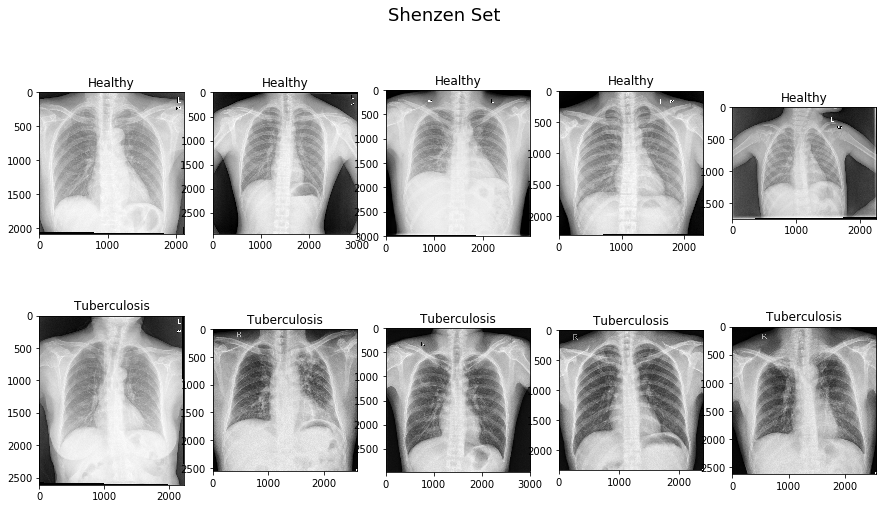

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from random import sample
import numpy as np
import glob
%matplotlib inline

mont_tb_neg = glob.glob('Data/MontgomerySet/CXR_png/*_0.png')
mont_tb_pos = glob.glob('Data/MontgomerySet/CXR_png/*_1.png')
shen_tb_neg = glob.glob('Data/ChinaSet_AllFiles/CXR_png/*_0.png')
shen_tb_pos = glob.glob('Data/ChinaSet_AllFiles/CXR_png/*_1.png')

mont_set = mont_tb_neg + mont_tb_pos
shen_set = shen_tb_neg + shen_tb_pos

mont_tb_neg_sample = sample(mont_tb_neg, 5)
mont_tb_pos_sample = sample(mont_tb_pos, 5)
shen_tb_neg_sample = sample(shen_tb_neg, 5)
shen_tb_pos_sample = sample(shen_tb_pos, 5)

mont_fig = plt.figure(figsize=(15,8))
mont_fig.suptitle('Montgomery County Set', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    img = mpimg.imread(filename)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

plt.show()

shen_fig = plt.figure(figsize=(15,8))
shen_fig.suptitle('Shenzen Set', size=18)
for i, filename in enumerate(shen_tb_neg_sample + shen_tb_pos_sample):
    img = mpimg.imread(filename)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')
        
plt.show()

### Observations
Since all Montgomery County images have a default size of either 4,020×4,892 or 4,892×4,020 pixels, while the actual X-ray size varies, some images contain empty space (black background). For the Shenzen Set this is not the case, but here the image sizes vary more.

## Pre-processing
### Step 1: Trim the Montgomery set images to remove empty space

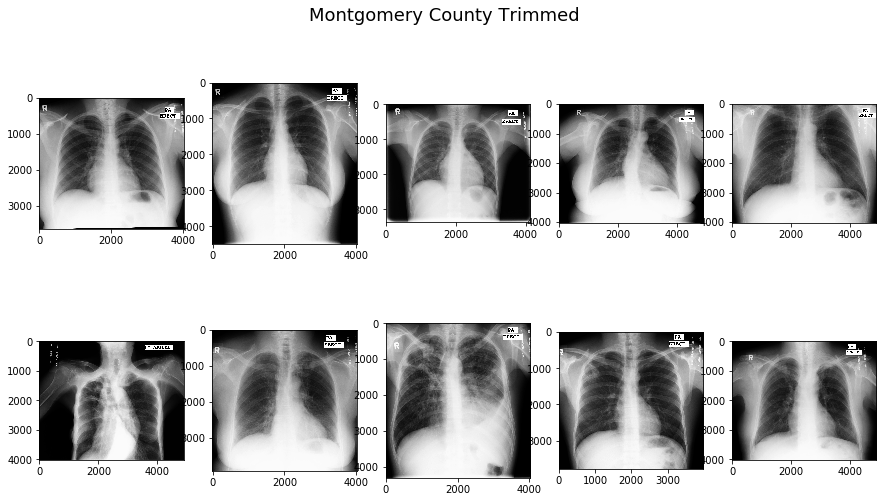

In [2]:
from PIL import Image, ImageChops
import numpy as np

def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

# This code was used to trim the images:
# for filename in mont_set:
#     trim(Image.open(filename)).save(filename.replace('CXR_png', 'trimmed'))

trim_fig = plt.figure(figsize=(15,8))
trim_fig.suptitle('Montgomery County Trimmed', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.array(Image.open(filename.replace('CXR_png', 'trimmed'))), cmap='gray')
    
plt.show()

### Observations
Now that the empty space of the Montgomery County images is trimmed away, the image sizes vary more.

### Step 2: Compress all images to 1024 x 1024 pixels

### Observations

### Step 3: Apply bone shadow suppression
For this step we used the pretrained model from  [https://github.com/hmchuong/ML-BoneSuppression](https://github.com/hmchuong/ML-BoneSuppression)

### Step 4: Reconstruct the images using an autoencoder

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(data)

import numpy as np
import random

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(4892, 4020))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(4892, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model


decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

mont_set.sort()
random.seed(42)
random.shuffle(mont_set) # shuffles the ordering of the data

split_1 = int(0.8 * len(mont_set))
split_2 = int(0.9 * len(mont_set))
x_train = np.array(mont_set[:split_1])
#dev_filenames = mont_set[split_1:split_2]
x_test = np.array(mont_set[split_2:])

x_train = x_train.reshape((len(x_train), int(np.prod(x_train.shape[1:]))))
x_test = x_test.reshape((len(x_test), int(np.prod(x_test.shape[1:]))))

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# use Matplotlib 
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))

for img in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Observations

## ELM classifier
Train and test a binary ELM classifier using the extension for scikit-learn. Evaluate it for both of the datasets with an ROC-curve and a confusion matrix.

Useful article: [https://ieeexplore.ieee.org/document/7140733](https://ieeexplore.ieee.org/document/7140733)

In [ ]:
from hpelm import ELM
from sklearn.metrics import roc_curve
from mlxtend.plotting import plot_confusion_matrix

# Pseudocode until pre-processing is done

# elm = ELM(input_dims, output_dims)
# elm.add_neurons()

# train & test ELM (cross-validation)

# plot ROC-curve

# plot_confusion_matrix(elm.confusion(T, Y), colorbar=True)
# plt.show()

### Observations

## Conclusion